In [1]:
from config import config
import os
import sys
sys.path.append(config.PROJECT_ROOT)

import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow_datasets as tfds
import tensorflow as tf
from utils import compute_mfcc_tf, scheduler, acc_loss_plot, split_distribution, plot_distributions, create_summary
from Models.model_11 import Model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

tf.random.set_seed(config. SEED)

/Users/traveler/Desktop/VSCODEs/research/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wave_path = "/Users/traveler/Downloads/output_4Mu6Y7Yz3C-V_1.wav"
audio = tf.io.read_file(wave_path)
audio, sr = tf.audio.decode_wav(audio, desired_channels=1)
audio = tf.squeeze(audio, axis=-1)
Audio(audio.numpy(), rate=sr.numpy())

In [3]:
mfcc = compute_mfcc_tf(audio, sr)

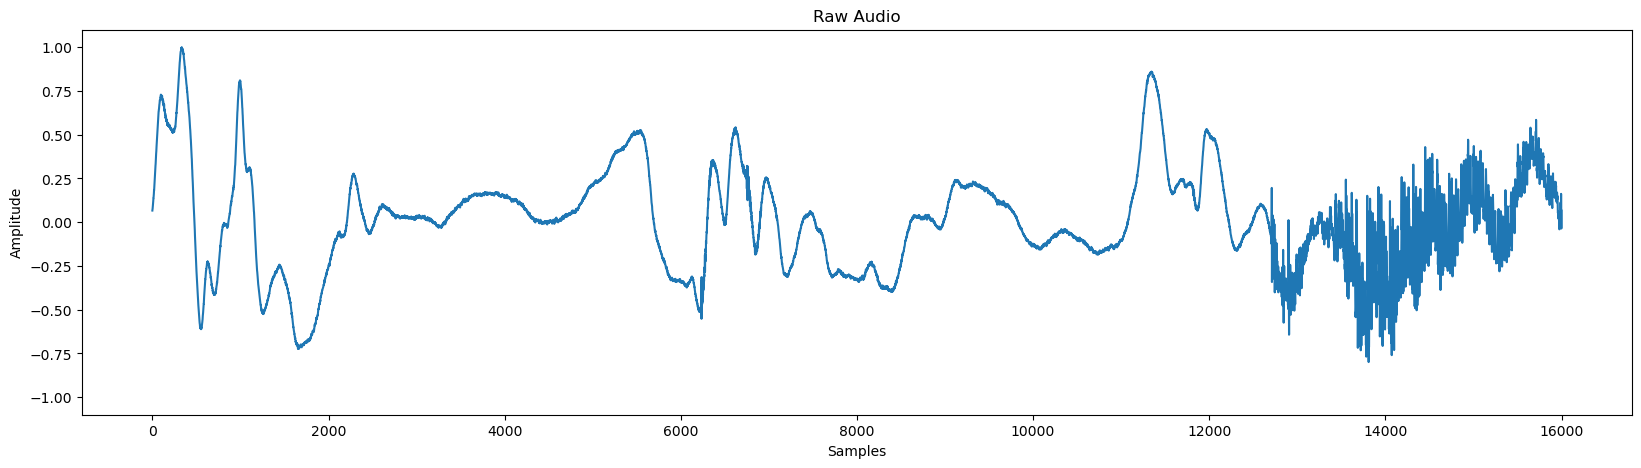

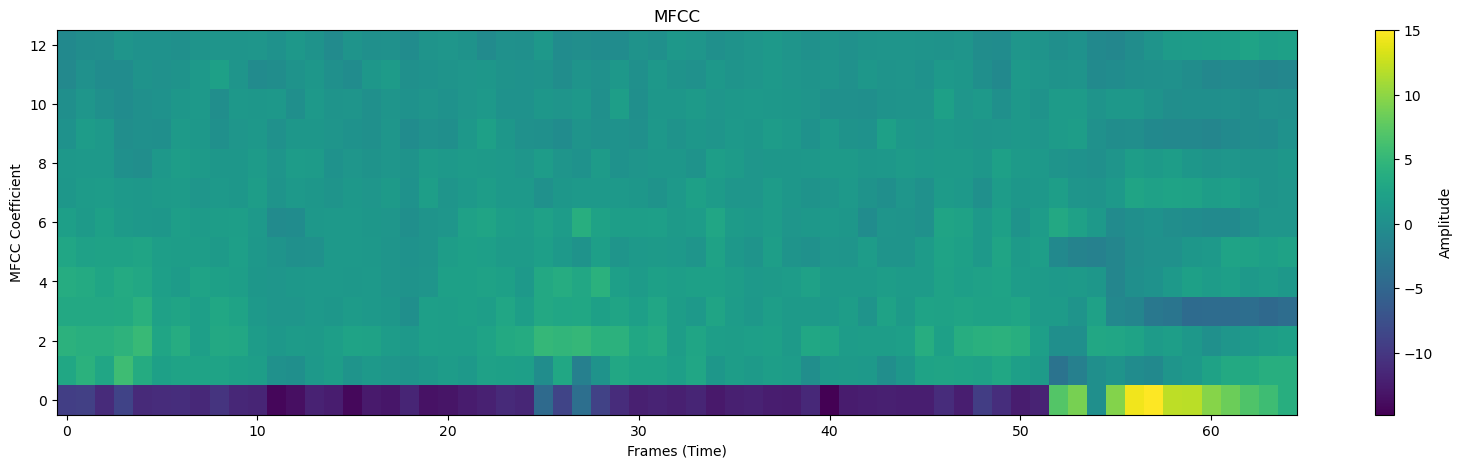

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(audio)
plt.title("Raw Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
_ = plt.ylim([-1.1, 1.1])

plt.figure(figsize=(20, 5))
plt.imshow(mfcc.numpy().T, aspect='auto', origin='lower')
plt.title("MFCC")
plt.xlabel("Frames (Time)")
plt.ylabel("MFCC Coefficient")
plt.colorbar(label="Amplitude")
plt.show()

In [5]:
(ds_train, ds_val, ds_test), ds_info = tfds.load("speech_commands", split=['train', 'validation', 'test'], as_supervised=True, with_info=True)
print(len(ds_train), "-",ds_train.element_spec)
print("-"*70)
print(len(ds_val), "-",ds_val.element_spec)
print("-"*70)
print(len(ds_test), "-",ds_test.element_spec)

85511 - (TensorSpec(shape=(None,), dtype=tf.int16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
----------------------------------------------------------------------
10102 - (TensorSpec(shape=(None,), dtype=tf.int16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
----------------------------------------------------------------------
4890 - (TensorSpec(shape=(None,), dtype=tf.int16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


2025-11-03 16:33:26.845768: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


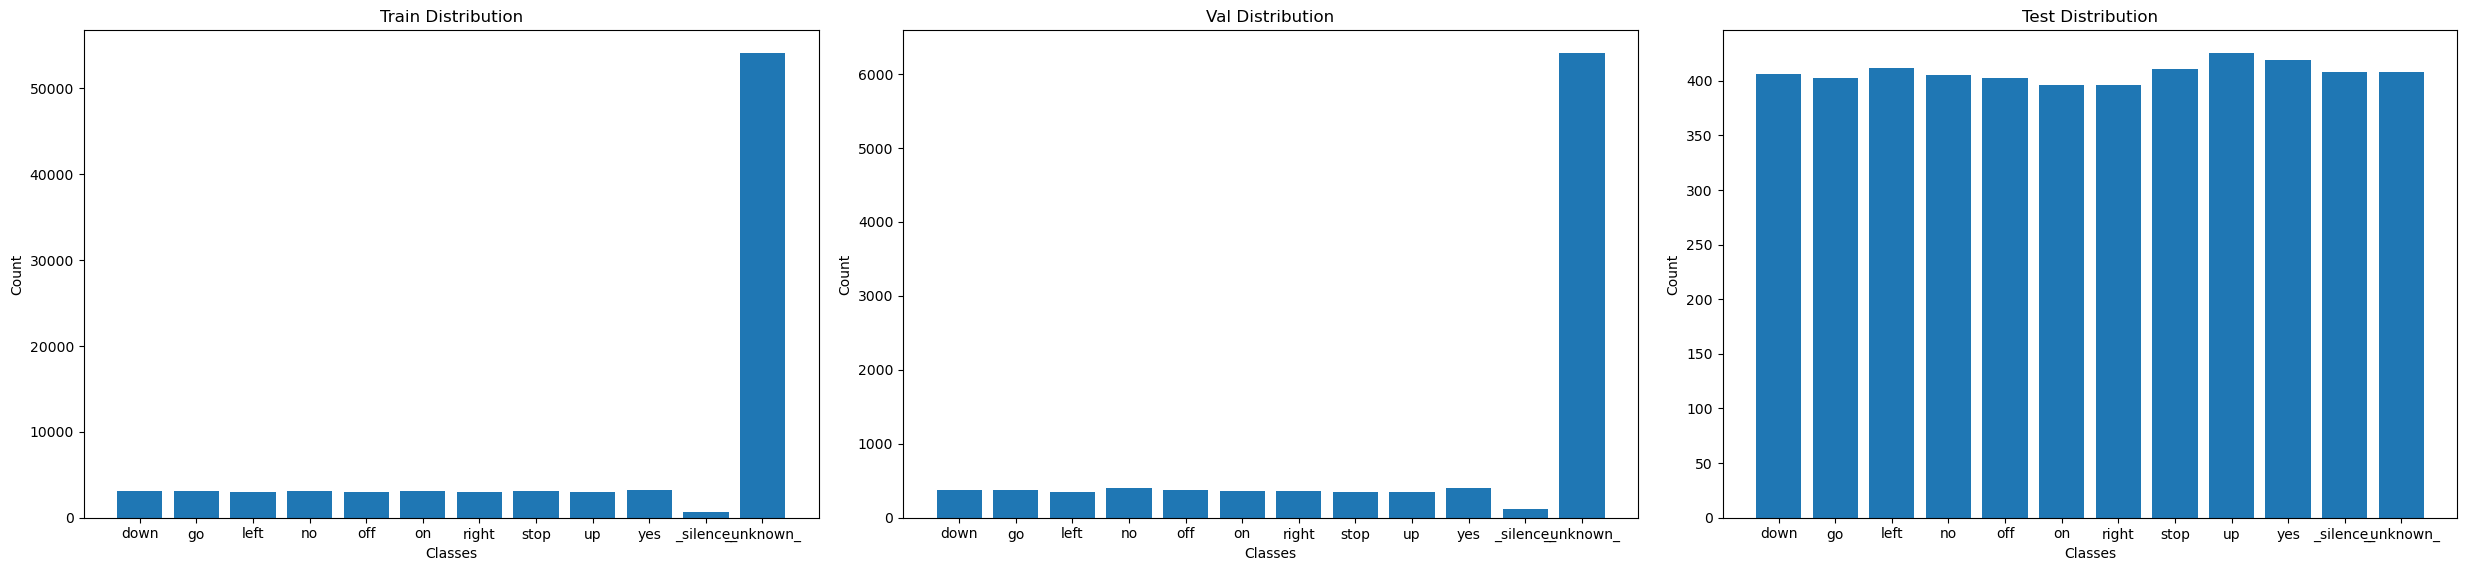

In [6]:
train_dist, _ = split_distribution(ds_train, ds_info)
val_dist, _ = split_distribution(ds_val, ds_info)
test_dist, test_labels = split_distribution(ds_test, ds_info, give_labels=True)
plot_distributions(train_dist, val_dist, test_dist)

In [7]:
def preprocess(audio, label):
	audio = tf.cast(audio, tf.float32) / 32768.0
	desired_length = 16000
	audio = tf.cond(
		tf.shape(audio)[0] < desired_length,
		lambda: tf.pad(audio, [[0, desired_length - tf.shape(audio)[0]]]),
		lambda: audio[:desired_length]
	)
	mfcc = compute_mfcc_tf(audio, config.SR)
	# mfcc = tf.expand_dims(mfcc, axis=-1)
	label = tf.one_hot(label, config.NUM_CLASSES)
	return mfcc, label

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(config.BATCH_SIZE)
ds_train = ds_train.prefetch(config.BATCH_SIZE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.batch(config.BATCH_SIZE)
ds_val = ds_val.prefetch(config.BATCH_SIZE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(config.BATCH_SIZE)
ds_test = ds_test.prefetch(config.BATCH_SIZE)

In [8]:
model = Model()
model.build(input_shape = [config.BATCH_SIZE, *config.INPUT_SHAPE])
os.makedirs(f"{config.RESULTS_DIR}/{model.name}", exist_ok=True)

config.model_name = model.name

In [9]:
model.compile(
	optimizer = tf.keras.optimizers.legacy.Adam(0.001),
	loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
	metrics = [
		tf.keras.metrics.CategoricalAccuracy(),
		# tf.keras.metrics.F1Score(),
	],
)

In [10]:
history = model.fit(
	ds_train,
	validation_data = ds_val,
	epochs = 100,
	verbose = 2,
	callbacks = [
		tf.keras.callbacks.LearningRateScheduler(
			scheduler,
			verbose=0,
		),
		tf.keras.callbacks.ModelCheckpoint(
			config.BEST_WEIGHTS_PATH,
			monitor='val_loss',
			verbose=0,
			save_best_only=True,
			save_weights_only=True,
			mode='min',
		)
	]
)

Epoch 1/100
1337/1337 - 47s - loss: 1.3251 - categorical_accuracy: 0.6389 - val_loss: 1.1381 - val_categorical_accuracy: 0.6425 - lr: 0.0010 - 47s/epoch - 35ms/step
Epoch 2/100
1337/1337 - 8s - loss: 0.9709 - categorical_accuracy: 0.6901 - val_loss: 0.8653 - val_categorical_accuracy: 0.7305 - lr: 0.0010 - 8s/epoch - 6ms/step
Epoch 3/100
1337/1337 - 8s - loss: 0.7638 - categorical_accuracy: 0.7549 - val_loss: 0.7312 - val_categorical_accuracy: 0.7822 - lr: 0.0010 - 8s/epoch - 6ms/step
Epoch 4/100
1337/1337 - 8s - loss: 0.6746 - categorical_accuracy: 0.7859 - val_loss: 0.6110 - val_categorical_accuracy: 0.8108 - lr: 0.0010 - 8s/epoch - 6ms/step
Epoch 5/100
1337/1337 - 8s - loss: 0.6166 - categorical_accuracy: 0.8052 - val_loss: 0.5499 - val_categorical_accuracy: 0.8291 - lr: 0.0010 - 8s/epoch - 6ms/step
Epoch 6/100
1337/1337 - 8s - loss: 0.5692 - categorical_accuracy: 0.8196 - val_loss: 0.5255 - val_categorical_accuracy: 0.8393 - lr: 0.0010 - 8s/epoch - 6ms/step
Epoch 7/100
1337/1337 - 8

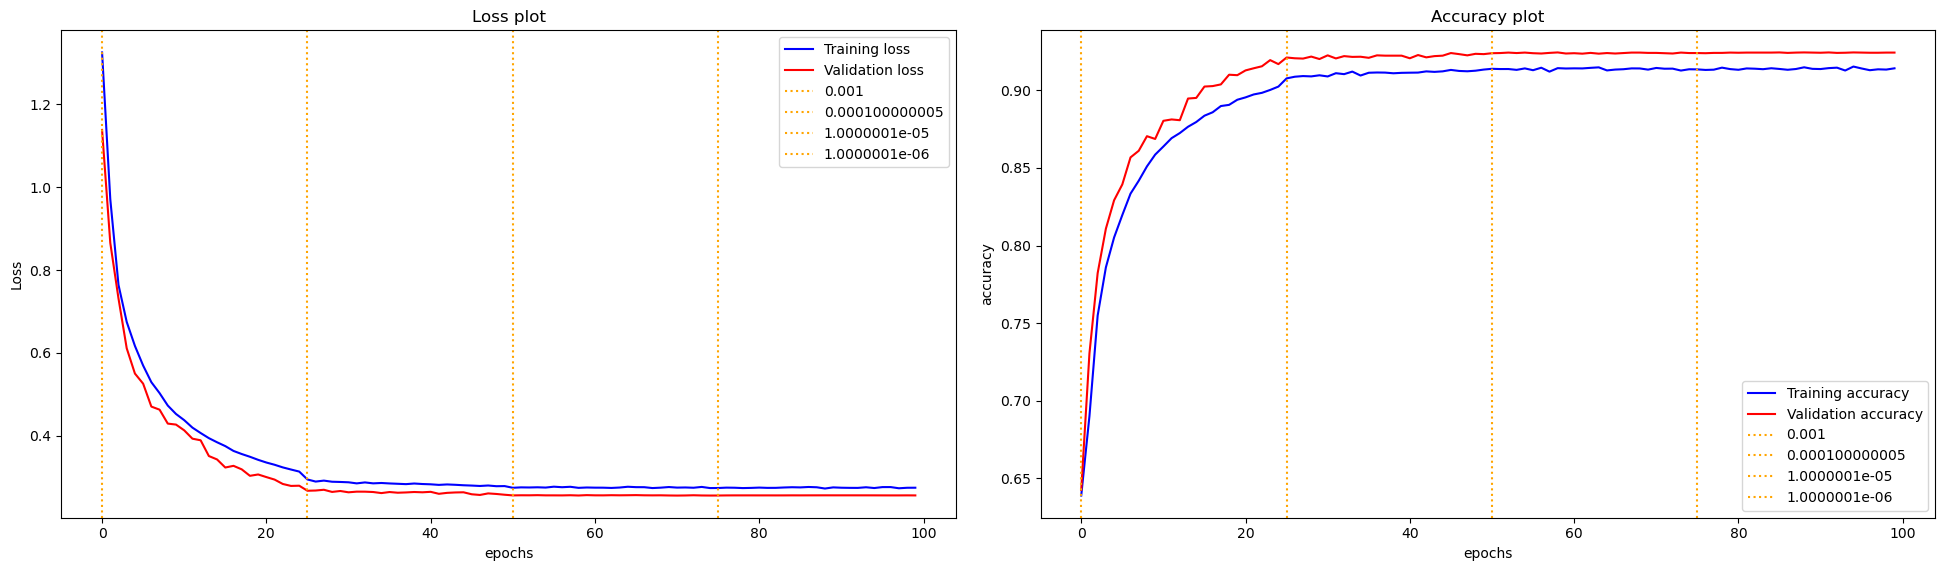

In [11]:
acc_loss_plot(history.history, size = [20, 6], path = config.TRAIN_PLOT_PATH)

In [12]:
model.evaluate(ds_test)
model.load_weights(config.BEST_WEIGHTS_PATH)
model.evaluate(ds_test)

77/77 [==============================] - 0s 2ms/step - loss: 0.5040 - categorical_accuracy: 0.8331


[0.5040117502212524, 0.833128809928894]

In [13]:
model.load_weights(config.BEST_WEIGHTS_PATH)
model.evaluate(ds_test)

77/77 [==============================] - 0s 2ms/step - loss: 0.5040 - categorical_accuracy: 0.8331


[0.5040117502212524, 0.833128809928894]

In [14]:
preds = model.predict(ds_test)
pred_labels = []
for pred in preds:
	pred_labels.append(int(tf.argmax(pred)))

77/77 [==============================] - 0s 2ms/step


In [15]:
report = classification_report(test_labels, pred_labels, target_names = ds_info.features["label"].names)
print(report)

with open(config.CLS_REPORT_PATH, "w") as f:
    f.write(report)

              precision    recall  f1-score   support

        down       0.92      0.78      0.84       406
          go       0.93      0.75      0.83       402
        left       0.97      0.84      0.90       412
          no       0.90      0.83      0.86       405
         off       0.91      0.84      0.87       402
          on       0.97      0.82      0.89       396
       right       1.00      0.81      0.90       396
        stop       0.97      0.82      0.89       411
          up       0.92      0.82      0.87       425
         yes       0.93      0.90      0.92       419
   _silence_       1.00      0.81      0.90       408
   _unknown_       0.39      0.97      0.56       408

    accuracy                           0.83      4890
   macro avg       0.90      0.83      0.85      4890
weighted avg       0.90      0.83      0.85      4890



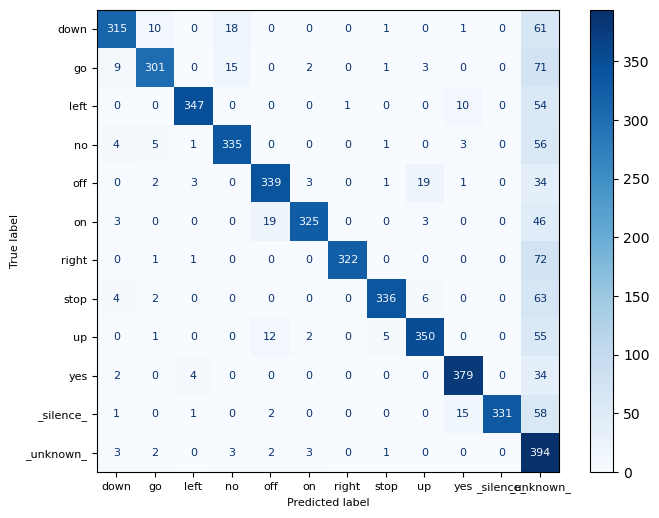

In [16]:
cm = confusion_matrix(test_labels, pred_labels)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ds_info.features["label"].names)
fig, ax = plt.subplots(figsize=(8, 6))
cm_plot.plot(ax=ax, cmap="Blues")
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
for text in ax.texts:
    text.set_fontsize(8)
ax.set_xlabel("Predicted label", fontsize=8)
ax.set_ylabel("True label", fontsize=8)
plt.savefig(config.CM_PATH, dpi = 300)

In [17]:
dummy_input = tf.random.normal(shape=(config.BATCH_SIZE, *config.INPUT_SHAPE))
create_summary(model, dummy_input, path=config.MODEL_SUMMARY_PATH)

Model: model_11
------------------------------------------------------------------------------------------
Layer                         Output Shape                  Params                        
------------------------------------------------------------------------------------------
separable_conv1d (SeparableC  (64, 63, 16)                  263 + 0                       
onv1D)                                                                                    

separable_conv1d_1 (Separabl  (64, 61, 16)                  320 + 0                       
eConv1D)                                                                                  

separable_conv1d_2 (Separabl  (64, 59, 32)                  592 + 0                       
eConv1D)                                                                                  

separable_conv1d_3 (Separabl  (64, 57, 64)                  2208 + 0                      
eConv1D)                                                               